In [1]:
import os
import preprocess_subject_data
import model_ed_tcn as md
import numpy as np


Using TensorFlow backend.


In [2]:
model_obj = md.ED_TCN_fmap_fuse(
    n_classes=12,
    input_length=256,
    early_fuse_cnn_channels=64,
    tcn_encoder_channels=[64]*4,
    tcn_decoder_channels=[64]*4,
    tcn_encoder_maxpool_size=[2]*4,
    tcn_decoder_upsample_size=[2, 2, 2, 2],
    early_fuse_conv_kernel_size=3,
    before_encode_pool_size=2,
    tcn_kernel_size=5,
    tcn_drop_rate=0.3,
    use_spatial_drop=True,
    drop_rate_before_midfc=0.5,
    drop_rate_before_fcclassifier=0.5,
    use_init_batch_norm=True,
)

In [3]:
def create_model(learning_rate=0.001):
    global model_obj
    
    model = model_obj.create_model()
    
    import tensorflow
    model.compile(optimizer=tensorflow.keras.optimizers.Adam(lr=learning_rate),loss='categorical_crossentropy',metrics=['accuracy'])
    
    return model

In [4]:
model = create_model()
model.summary()

AttributeError: 'tuple' object has no attribute 'layer'

In [ ]:
folder_path = 'PAMAP2_256_ws'
num_of_subjects = 9

x_data, y_data, labels = preprocess_subject_data.load_data('../PAMAP2_dataset/' + folder_path + '/PAMAP2/preprocessed', num_of_subjects)

In [ ]:

train_results = []
num_of_subjects = 36
learning_rate = 1e-3
batch_size = 32

# count = 0
# sum = 0

# print('Train with learning rate ' + str(learning_rate) + ' and batch size ' + str(batch_size))


# x_valid_list = x_data[0:3]
# y_valid_list = y_data[0:3]

# x_train_list = x_data[3:9]
# y_train_list = y_data[3:9]


# x_valid = np.concatenate(tuple(x_valid_list))
# y_valid = np.concatenate(tuple(y_valid_list))
# x_train = np.concatenate(tuple(x_train_list))
# y_train = np.concatenate(tuple(y_train_list))


# model = create_model(learning_rate)


# my_callbacks = [
#     keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_accuracy:.2f}.h5',
#                                        monitor="val_accuracy",
#                                        save_best_only=True)
# ]


# H = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), callbacks=my_callbacks, batch_size=batch_size, epochs=20, verbose=1)

n_rep = 30

sum = 0

for _ in range(n_rep):
    print('Trainning_time: ' + str(_))
    x_valid_list = x_data[0:3]
    y_valid_list = y_data[0:3]

    x_train_list = x_data[3:9]
    y_train_list = y_data[3:9]


    x_valid = np.concatenate(tuple(x_valid_list))
    y_valid = np.concatenate(tuple(y_valid_list))
    x_train = np.concatenate(tuple(x_train_list))
    y_train = np.concatenate(tuple(y_train_list))


    model = create_model(learning_rate)


#     my_callbacks = [
#         keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_accuracy:.2f}.h5',
#                                            monitor="val_accuracy",
#                                            save_best_only=True)
#     ]


    H = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), batch_size=batch_size, epochs=20, verbose=0)
    
    best_acc = np.max(H.history['val_accuracy'])
    sum += best_acc
    print('Best acc: ' + str(best_acc))

    
print('Mean acc: ' + str(sum / n_rep))

                   precision    recall  f1-score   support

            lying       0.88      0.93      0.90       660
          sitting       0.82      0.67      0.74       680
         standing       0.82      0.45      0.58       612
          walking       0.96      0.92      0.94       771
          running       0.58      0.99      0.73       261
          cycling       0.57      1.00      0.73       443
   nordic_walking       0.89      0.98      0.94       456
 ascending_stairs       0.63      0.14      0.22       303
descending_stairs       1.00      0.50      0.67       300
 vaccuum_cleaning       0.52      0.39      0.44       573
          ironing       0.56      0.99      0.71       739
     rope_jumping       0.00      0.00      0.00       218

        micro avg       0.72      0.72      0.72      6016
        macro avg       0.69      0.66      0.63      6016
     weighted avg       0.73      0.72      0.69      6016

Normalized confusion matrix


/anaconda/envs/azureml_py36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


<Figure size 432x288 with 0 Axes>

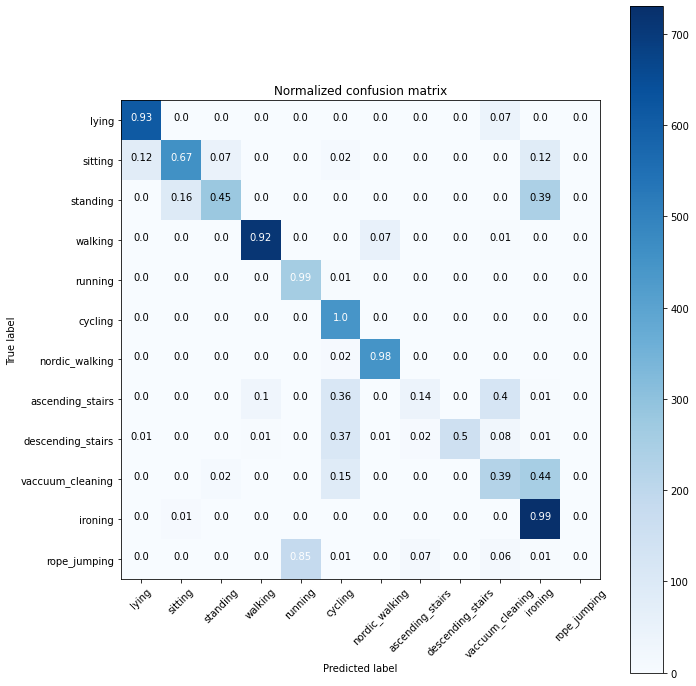

In [10]:
import tensorflow
from model_sa_tcn import Trainabble_Multiply

model = keras.models.load_model('model.01-0.72.h5',
              custom_objects={'Trainabble_Multiply':Trainabble_Multiply})

y_true = np.argmax(y_valid, axis = 1)
y_pred = model.predict(x_valid)
y_pred = np.argmax(y_pred, axis = 1)

import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


def show_classification_report(y_true, y_pred, digits=4, labels=None, save_path=None):
    """
    :param y_true: 1d array containing y true
    :param y_pred: 1d array containing y pred
    :param digits: number of digits to show
    :param labels: list label names
    :param save_path: path to save report
    """

    # Select only existing labels from y true and y pred
    unique_labels = np.unique(np.array([y_true, y_pred])).astype(np.int)
    labels = labels[unique_labels]

    # show report
    report = classification_report(y_true, y_pred, digits=digits, target_names=labels)
    print(report)

    # save to file
    if save_path is not None:
        with open(save_path, 'w') as f:
            f.write(report)


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

class_names = np.array(['lying',
 'sitting',
 'standing',
 'walking',
 'running',
 'cycling',
 'nordic_walking',
 'ascending_stairs',
 'descending_stairs',
 'vaccuum_cleaning',
 'ironing',
 'rope_jumping'])
    
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)

# Show classificaiton report
show_classification_report(y_true, y_pred, digits=2, labels=class_names)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,normalize = True,
                      title='Normalized confusion matrix')

plt.show()